# Regressão linear

Vamos considerar o problema de prever a idade de um conjunto de crianças e jovens com idade entre 1 e 20 anos a partir da altura delas

### Leitura dos dados

Text(0, 0.5, 'Idade')

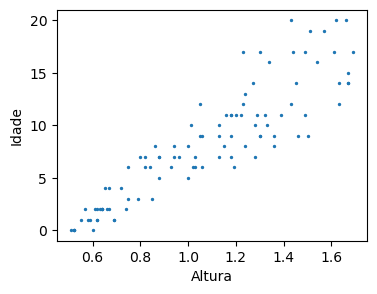

In [15]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("../data/age_data_1.txt")
x, y = data.T

plt.scatter(x, y, s=2)
plt.xlabel("Altura")
plt.ylabel("Idade")

### Modelo linear

Vamos definir um modelo linear para representar os dados. Vamos supor que a idade de uma pessoa é dada por

$y_m = ax + b$

onde x é a altura e y a idade.

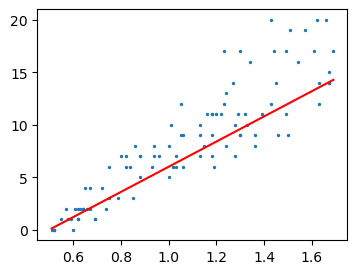

In [16]:
class Model:
    """Modelo linear com parâmetros `a` e `b`."""

    def __init__(self, a, b):

        self.a = a
        self.b = b

    def __call__(self, x):
        y = self.a*x + self.b
        return  y
    
    def copy(self):
        return Model(self.a, self.b)

model = Model(a=12, b=-6)

xm = np.linspace(x.min(), x.max())
ym = model(xm)

plt.scatter(x, y, s=2)
plt.plot(xm, ym, "r")

### Erro quadrático médio

O erro quadrático médio é dado por

$$
mse = \frac{1}{n}\sum_{i=1}^{n}(y(i)-y_m(i))^2
$$

In [17]:
def mse(model, x, y):

    ym = model(x)
    error = np.mean((y-ym)**2)

    return error

error = mse(model, x, y)
print(error)

8.027488


Vamos criar funções para plotar o erro que teríamos se modificássemos os parâmetros do nosso modelo

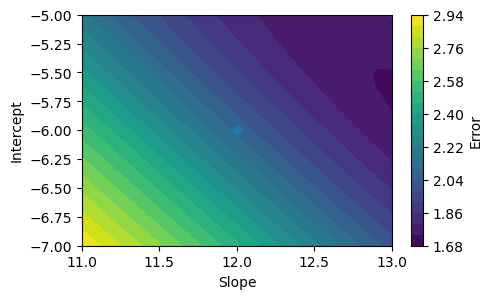

In [18]:
def get_local_error(model, x, y, par_range):
    """Calcula o erro quadrático médio entre `x` e `y` para combinações de 
    parâmetros do modelo no intervalo [a-par_range, a+par_range] e [b-par_range, b+par_range]."""
    
    # Número de pontos
    size = 20
    # Parâmetros do modelo
    a, b = model.a, model.b
    # Possíveis parâmetros do modelo
    a_vals = np.linspace(a-par_range, a+par_range, size)
    b_vals = np.linspace(b-par_range, b+par_range, size)

    # Avalia o modelo para cada combinação de parâmetros
    error_grid = np.zeros((size, size))
    for i, b_val in enumerate(b_vals):
        for j, a_val in enumerate(a_vals):
            model_close = Model(a_val, b_val)
            error = mse(model_close, x, y)
            error_grid[i,j] = error
            
    return error_grid, a_vals, b_vals

def plot_local_error(model, x, y, par_range=1.):
    """Plota o erro quadrático médio para diversos parâmetros do modelo."""
    
    error_grid, a_vals, b_vals = get_local_error(model, x, y, par_range)
    
    plt.figure(figsize=(5,3))
    # A função np.log ajuda a diferenciar valores muito parecidos
    plt.contourf(a_vals, b_vals, np.log(error_grid), levels=20)

    cbar = plt.colorbar()
    cbar.set_label("Error")
    plt.scatter(model.a, model.b)
    plt.xlabel("Slope")
    plt.ylabel("Intercept")


plot_local_error(model, x, y)

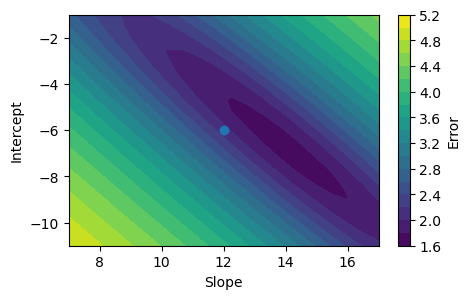

In [19]:
# Visualizando um intervalo maior de parâmetros
plot_local_error(model, x, y, par_range=5)

### Otimização de gradiente descendente

O gradiente do erro quadrático médio é calculado como

$$
\frac{\partial{mse}}{\partial{a}} = -\frac{2}{n}\sum_{i=1}^n (y(i)-ax(i)-b)x(i)
$$
$$
\frac{\partial{mse}}{\partial{b}} = -\frac{2}{n}\sum_{i=1}^n (y(i)-ax(i)-b)
$$

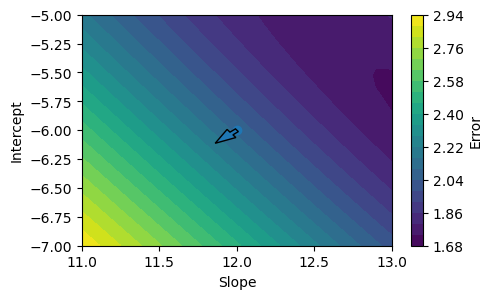

In [20]:
def mse_grad(model, x, y):
    """Gradiente do erro quadrático médio."""

    n = len(x)
    ym = model(x)
    ga = -2*np.sum((y-ym)*x)/n
    gb = -2*np.sum(y-ym)/n

    return ga, gb

grad = mse_grad(model, x, y)

plot_local_error(model, x, y)
# Plota uma seta na direção do gradiente, lr define o comprimento da seta
# em relação ao comprimento original do gradiente
lr = 0.01
plt.arrow(model.a, model.b, lr*grad[0], lr*grad[1], width=0.03)

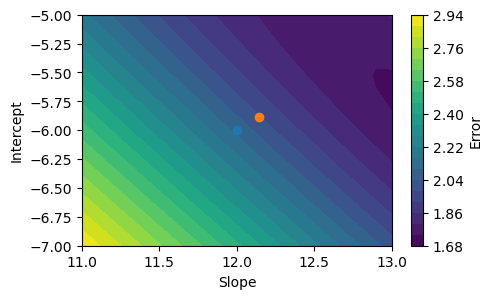

In [21]:
def step(model, x, y, lr):
    """Dá um passo de gradiente descendente. Os parâmetros do modelo
    são modificados in-place."""

    grad = mse_grad(model, x, y)
    # Modifica os parâmetros na direção contrária do gradiente
    model.a = model.a - lr*grad[0]
    model.b = model.b - lr*grad[1]

# Copia modelo original para plotar
model_or = model.copy()

step(model, x, y, lr=0.04)
plot_local_error(model_or, x, y)
plt.scatter(model.a, model.b)

Vamos tentar dar um passo um pouco maior

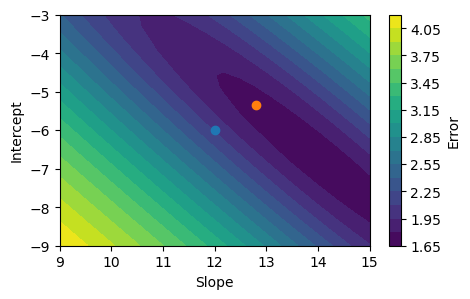

In [22]:
model = model_or.copy()

step(model, x, y, lr=0.23)
plot_local_error(model_or, x, y, par_range=3)
plt.scatter(model.a, model.b)

Vamos dar mais um passo usando gradiente descendente

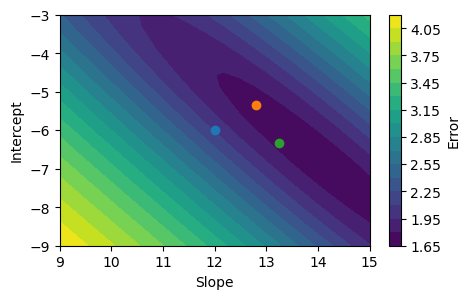

In [23]:
model_1_step = model.copy()
step(model, x, y, lr=5)

plot_local_error(model_or, x, y, par_range=3)
plt.scatter(model_1_step.a, model_1_step.b)
plt.scatter(model.a, model.b)

### Criando um loop de treinamento

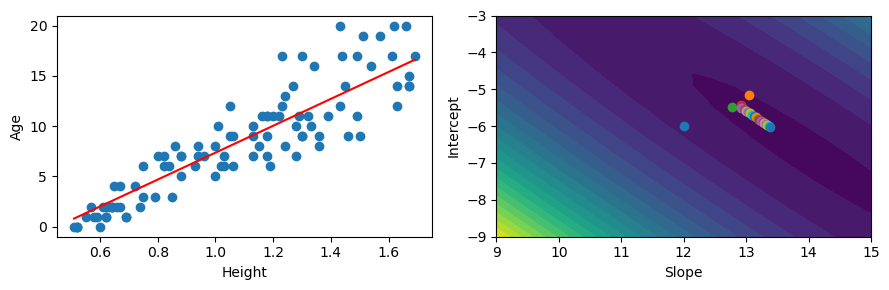

CPU times: user 1.42 s, sys: 15.8 ms, total: 1.44 s
Wall time: 1.43 s


In [ ]:
%%time
from IPython import display

def train(model, x, y, lr, num_epochs):

    fig = plot_figure(model, x, y)

    for epoch in range(0, num_epochs):
        step(model, x, y, lr)
        plot_figure(model, x, y, fig)

def plot_figure(model, x, y, fig=None):

    # Aplica o modelo para valores entre x.min() e x.max()
    xm = np.linspace(x.min(), x.max())
    ym = model(xm)

    if fig is None:
        error_grid, a_vals, b_vals = get_local_error(model, x, y, par_range=3)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))
        # Plot 1
        ax1.scatter(x, y)
        ax1.plot(xm, ym, color="r")
        ax1.set_xlabel("Height")
        ax1.set_ylabel("Age")
        # Plot 2
        ax2.contourf(a_vals, b_vals, error_grid, levels=20)
        ax2.scatter(model.a, model.b)
        ax2.set_xlabel("Slope")
        ax2.set_ylabel("Intercept")
        plt.tight_layout()
        
        plt.close()
    else:
        # Atualiza somente a linha do plot 1 e os pontos do plot 2
        ax1, ax2 = fig.axes
        ax1.lines[0].set_data(xm, ym)
        ax2.scatter(model.a, model.b)

    # Remove o plot anterior
    display.clear_output(wait=True) 
    display.display(fig)
    
    return fig

model = Model(a=12, b=-6)
num_epochs = 20
lr = 0.3
train(model, x, y, lr, num_epochs)

### Regressão linear com duas variáveis

Quando os valores de entrada possuem duas variáveis, também temos um problema de regressão linear. Vamos utilizar o modelo

$$
y_m = w_1x_1 + w_2x_2 + b
$$

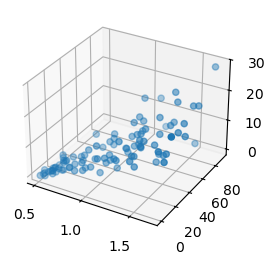

In [25]:
data = np.loadtxt("../data/age_data_2.txt")
x1, x2, y = data.T

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(x1, x2, y)

Text(0.5, 0, 'Age')

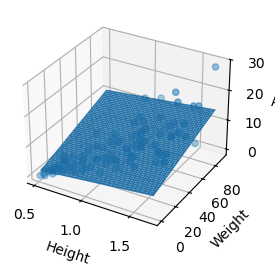

In [26]:
# Descomente para criar uma figura interativa
#%matplotlib widget
class Model:
    """Modelo linear de dois pesos e um bias."""

    def __init__(self, w1, w2, b):

        self.w1 = w1
        self.w2 = w2
        self.b = b

    def __call__(self, x1, x2):
        y = self.w1*x1 + self.w2*x2 + self.b
        return  y

model = Model(w1=3., w2=0.1, b=0)
x1m, x2m = np.meshgrid(
    np.linspace(x1.min(), x1.max()),
    np.linspace(x2.min(), x2.max())
    )
ym = model(x1m, x2m)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(x1, x2, y)
ax.plot_surface(x1m, x2m, ym)
ax.set_xlabel("Height")
ax.set_ylabel("Weight")
ax.set_zlabel("Age")

A otimização será exatamente igual à realizada acima. A única diferença é que teremos um parâmetro a mais para otimizar:

In [27]:
def mse(model, x1, x2, y):

    ym = model(x1, x2)
    error = np.mean((y-ym)**2)

    return error

def mse_grad(model, x1, x2, y):

    n = len(x1)
    ym = model(x1, x2)
    gw1 = -2*np.sum((y-ym)*x1)/n
    gw2 = -2*np.sum((y-ym)*x2)/n
    gb = -2*np.sum(y-ym)/n

    return gw1, gw2, gb

def step(model, x1, x2, y, lr):

    grad = mse_grad(model, x1, x2, y)
    model.w1 = model.w1 - lr*grad[0]
    model.w2 = model.w2 - lr*grad[1]
    model.b = model.b - lr*grad[2]

    return model